# Analysing variability and compensation mechansims with conditional distributions

A central advantage of `sbi` over parameter search methods such as genetic algorithms is that the it captures **all** models that can reproduce experimental data. This allows us to analyse whether parameters can be variable or have to be narrowly tuned, and to analyse compensation mechanisms between different parameters. See also [Marder and Taylor, 2006](https://www.nature.com/articles/nn.2735?page=2) for further motivation to identify **all** models that capture experimental data.  

In this tutorial, we will show how one can use the posterior distribution to identify whether parameters can be variable or have to be finely tuned, and how we can use the posterior to find potential compensation mechanisms between model parameters. To investigate this, we will extract **conditional distributions** from the posterior inferred with `sbi`.

Note, you can find the original version of this notebook at [https://github.com/mackelab/sbi/blob/main/tutorial/07_conditional_correlations.ipynb](https://github.com/mackelab/sbi/blob/main/tutorial/07_conditional_correlations.ipynb) in the `sbi` repository.

## Main syntax

In [ ]:
from sbi.utils import conditional_pairplot, conditional_corrcoeff

# Plot slices through posterior, i.e. conditionals.
_ = conditional_pairplot(
    density=posterior,
    condition=posterior.sample((1,)),
    limits=torch.tensor([[-2., 2.], [-2., 2.]]),
)

# Compute the matrix of correlation coefficients of the slices.
cond_coeff_mat = conditional_corrcoeff(
    density=posterior,
    condition=posterior.sample((1,)),
    limits=torch.tensor([[-2., 2.], [-2., 2.]]),
)
plt.imshow(cond_coeff_mat, clim=[-1, 1])

## Analysing variability and compensation mechanisms in a toy example
Below, we use a simple toy example to demonstrate the above described features. For an application of these features to a neuroscience problem, see figure 6 in [Gonçalves, Lueckmann, Deistler et al., 2019](https://arxiv.org/abs/1907.00770).

In [1]:
import sbi.utils as utils
from sbi.utils import pairplot, conditional_pairplot, conditional_corrcoeff
import torch
import matplotlib.pyplot as plt
import numpy as np

_ = torch.manual_seed(0)

Let's say we have used SNPE to obtain a posterior distribution over eight parameters. In this tutorial, we just load the posterior from a file:

In [2]:
from toy_posterior_for_07_cc import ExamplePosterior
posterior = ExamplePosterior()

First, we specify the experimental observation $x_o$ at which we want to evaluate and sample the posterior $p(\theta|x_o)$:

In [3]:
x_o = torch.ones(1, 20)  # simulator output was 20-dimensional
posterior.set_default_x(x_o)

As always, we can inspect the posterior marginals with the `pairplot()` function:

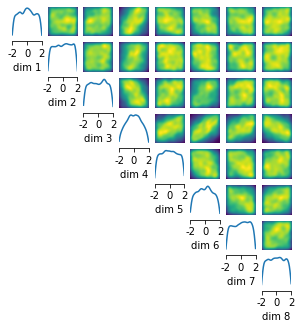

In [4]:
posterior_samples = posterior.sample((5000,))

fig, ax = pairplot(
    samples=posterior_samples,
    limits=torch.tensor([[-2., 2.]]*8),
    upper=['kde'],
    diag=['kde'],
    fig_size=(5,5)
)

The 1D and 2D marginals of the posterior fill almost the entire parameter space! Also, the Pearson correlation coefficient matrix of the marginal shows only weak interactions:

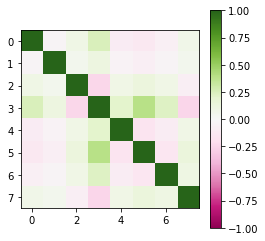

In [5]:
corr_matrix_marginal = np.corrcoef(posterior_samples.T)
fig, ax = plt.subplots(1,1, figsize=(4, 4))
im = plt.imshow(corr_matrix_marginal, clim=[-1, 1], cmap='PiYG')
_ = fig.colorbar(im)

It might be tempting to conclude that the experimental data barely constrains our parameters and that almost all parameter combinations can reproduce the experimental data. As we will show below, this is not the case.

Instead of inspecting the marginals of the posterior, we can also inspect 2D-slices through the posterior with the `conditional_pairplot()` function. Mathematically, we can do so by inspecting the conditional distributions. We can slice (i.e. condition) the posterior at any location, given by `condition`. In the plot below, for all upper diagonal plots, we keep all but two parameters constant at values sampled from the posterior, and inspect what combinations of the remaining two parameters can reproduce experimental data. For the plots on the diagonal (the 1D conditionals), we keep all but one parameter constant.

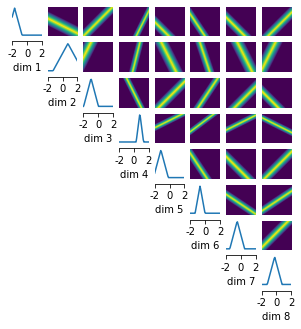

In [6]:
condition = posterior.sample((1,))

_ = conditional_pairplot(
    density=posterior,
    condition=condition,
    limits=torch.tensor([[-2., 2.]]*8),
    fig_size=(5,5)
)

This plot looks completely different from the marginals obtained with `pairplot()`. As it can be seen on the diagonal plots, if all parameters but one are kept constant, the remaining parameter has to be tuned to a narrow region in parameter space. In addition, the upper diagonal plots show strong correlations: deviations in one parameter can be compensated through changes in another parameter.

We can summarize these correlations in a conditional correlation matrix, which computes the Pearson correlation coefficient of each of these pairwise plots. This matrix (below) shows strong correlations between many parameters, which can be interpreted as potential compensation mechansims:

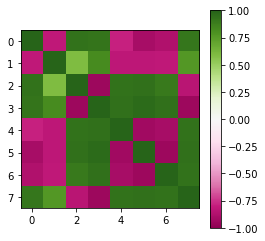

In [7]:
cond_coeff_mat = conditional_corrcoeff(
    density=posterior,
    condition=condition,
    limits=torch.tensor([[-2., 2.]]*8),
)
fig, ax = plt.subplots(1,1, figsize=(4, 4))
im = plt.imshow(cond_coeff_mat, clim=[-1, 1], cmap='PiYG')
_ = fig.colorbar(im)

So far, we have investigated the conditional distribution only at a specific `condition` sampled from the posterior. In many applications, it makes sense to repeat the above analyses with a different `condition` (another sample from the posterior), which can be interpreted as slicing the posterior at a different location. Note that `conditional_corrcoeff()` can directly compute the matrix for several `conditions` and then outputs the average over them. This can be done by passing a batch of $N$ conditions as the `condition` argument.